<a href="https://www.kaggle.com/code/catalystcooperative/05-ferc-714-electricity-demand-forecast-biases?scriptVersionId=262683409" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# exploring bias in load growth projections

This notebook (work in progress) explores the questions raised in [pudl-3910](https://github.com/catalyst-cooperative/pudl/issues/3910).

TODO:
* add narrative explanation of the analysis
* start exploring structure in some individual respondents
* start exploring territory/population changes

## table of contents

* [load and preprocess data](#preprocess)
* [rmi squid plot](#squid)
* [examples](#examples)
* [disorganized eda](#eda)

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

matplotlib.rcParams["figure.figsize"] = (10, 6)
matplotlib.rcParams["figure.dpi"] = 150

## load and preprocess data
<a class='anchor' id='preprocess'/>

In [2]:
# If you wanted to pull a different version of the data, swap the version string in for /nightly here
PARQUET_PATH = "s3://pudl.catalyst.coop/nightly"

def read_parquet(table_name: str, columns: list[str] | None = None) -> pd.DataFrame:
    """A helper function to read PUDL Parquet files."""
    table_path = f"{PARQUET_PATH}/{table_name}.parquet"
    return pd.read_parquet(table_path, dtype_backend="pyarrow", columns=columns)

In [3]:
forecast = read_parquet("core_ferc714__yearly_planning_area_demand_forecast")

In [4]:
hourly_demand = read_parquet("out_ferc714__hourly_planning_area_demand")

In [5]:
respondents = read_parquet("out_ferc714__summarized_demand")
# lowercase the string columns
for c in respondents.select_dtypes(include=["string[pyarrow]"]).columns:
    respondents[c] = respondents[c].str.lower()

## rmi squid plot <a class='anchor' id='squid'/>

We start by reproducing the squid plot, found [here](https://rmi.org/billion-dollar-costs-forecasting-electricity-demand/). This gives us an overview of the bias in respondents' average forecast errors by lookahead-year.

In [6]:
def squid_plot(
    forecast: pd.DataFrame,
    hourly_demand: pd.DataFrame,
    respondents: pd.DataFrame,
    demand_col: str = "demand_imputed_pudl_mwh",
    end_weighting: str = "total",
    first_year: int = 2006,
    last_year: int = 2024,
    load_weight_year: int = 2015,
    years_to_drop: list[int] = [],
    mean_annual_demand_threshold: int = 0,
):
    # We begin by calculating the actually-realized peak load for all respondents (for
    # all years). Note that there are rows where the report year is not equal to the
    # data year. We enforce equality and drop the rest.
    realized_peak = (
        hourly_demand.assign(
            year=hourly_demand.datetime_utc.dt.year,
            report_year=hourly_demand.report_date.dt.year,
        )
    )
    realized_peak = (
        realized_peak.loc[realized_peak.year == realized_peak.report_year]
        .groupby(["respondent_id_ferc714", "year", "report_year"], as_index=False)
        .agg(realized_peak=(demand_col, "max"))
    )
    # We also compute the actually-realized total yearly demand for all respondents (and
    # all years)
    realized_total = (
        hourly_demand.assign(
            year=hourly_demand.datetime_utc.dt.year,
            report_year=hourly_demand.report_date.dt.year,
        )
    )
    realized_total = (
        realized_total.loc[realized_total.year == realized_total.report_year]
        .groupby(["respondent_id_ferc714", "year", "report_year"], as_index=False)
        .agg(realized_total_demand=(demand_col, "sum"))
        .drop(columns=["year"])
    )
    # Next we look at the forecast data. We'll merge in the respondent name for
    # easy readability
    forecast_by_name = forecast[
        (forecast["report_year"] >= first_year) & (forecast["report_year"] <= last_year)
    ]
    # take the yearly peak demand forecast to be the maximum
    # of the summer and winter forecasts
    forecast_by_name["forecast"] = np.maximum(
        forecast_by_name["summer_peak_demand_forecast_mw"],
        forecast_by_name["winter_peak_demand_forecast_mw"],
    )
    forecast_by_name["lookahead"] = (
        forecast_by_name["forecast_year"] - forecast_by_name["report_year"]
    )
    forecast_by_name = forecast_by_name.merge(
        respondents[
            ["respondent_id_ferc714", "respondent_name_ferc714"]
        ].drop_duplicates(keep="last"),
        on="respondent_id_ferc714",
        how="left",
        validate="m:1",
    )[
        [
            "respondent_id_ferc714",
            "respondent_name_ferc714",
            "report_year",
            "forecast_year",
            "lookahead",
            "forecast",
        ]
    ]
    # The squid plot visualizes a respondent's average error in n-year forecasts, for
    # each n from 1 to 10 (recall that form FERC714 asks for 10-year forecasts). We
    # start by computing the error for each (respondent, report_year, forecast_year)
    # triple, which requires us to join the realized demand data with the forecasted
    # demand data.
    presquid = forecast_by_name.merge(
        realized_peak[["respondent_id_ferc714", "year", "realized_peak"]],
        left_on=["respondent_id_ferc714", "forecast_year"],
        right_on=["respondent_id_ferc714", "year"],
        how="inner",
        validate="m:1",
    )
    # drop all ids that are below the specified size
    if mean_annual_demand_threshold != 0:
        mean_annual_totals = realized_total.groupby(["respondent_id_ferc714"]).agg(
            mean_yearly_total_demand=("realized_total_demand", "mean")
        )
        mask_low = (
            mean_annual_totals.mean_yearly_total_demand >= mean_annual_demand_threshold
        )
        ids_to_keep = mean_annual_totals[mask_low].index.to_list()
        n_before = presquid.respondent_id_ferc714.nunique()
        presquid = presquid[presquid.respondent_id_ferc714.isin(ids_to_keep)]
        n_after = presquid.respondent_id_ferc714.nunique()
    # drop forecasts for designated years
    presquid = presquid[~presquid.year.isin(years_to_drop)].drop(columns=["year"])
    presquid.loc[(presquid.forecast != 0) & (presquid.realized_peak != 0), "error"] = (
        presquid.forecast - presquid.realized_peak
    ) / presquid.realized_peak
    # in the case that the error can't be computed, we fill with 0
    presquid["error"] = presquid["error"].fillna(0)
    presquid = presquid.pivot(
        index=["respondent_id_ferc714", "respondent_name_ferc714", "report_year"],
        columns="lookahead",
        values="error",
    )
    presquid = presquid[(presquid[1] < 100) | presquid[1].isna()].reset_index()

    # A couple things to note here before we group down to the respondent level. First
    # of all, we've dropped instances where the forecasted peak demand is zero as well
    # as instances where the error is undefined due to the realized peak demand
    # being 0. We've also dropped any crazy outliers.

    # Now we take a mean, grouped over the respondent. We'll drop rows where the
    # resulting mean has too many missing points as well as rows where the 1 and
    # 10-year lookahead errors are very high.
    squid = (
        presquid.drop(columns=["report_year"])
        .groupby(["respondent_id_ferc714", "respondent_name_ferc714"])
        .mean()
    )

    squid[0] = 0.0
    squid = squid[squid.isna().sum(axis=1) <= 5]
    # drop respondents whose average 1-year lookahead is too high
    squid = squid[squid[1].isna() | (squid[1].abs() <= 0.3)]
    # drop respondents whose average 10-year lookahead is way too high
    squid = squid[squid[10].isna() | (squid[10].abs() <= 1.0)]

    # Of course, many of these respondents are quite small in terms of the demand
    # served, while a few are quite large. As a result, if we want to understand the
    # big picture surrounding forecasting errors, we'll have to weight the errors by
    # the demand served: forecasting errors made by larger respondents are more
    # important than those made by smaller respondents. We provide two options here,
    # weighting by, in the load_weight_year, the peak or the total demand served

    if end_weighting == "peak":
        loaded_squid = squid.reset_index().merge(
            realized_peak.loc[realized_peak.report_year == load_weight_year][
                ["respondent_id_ferc714", "realized_peak"]
            ],
            how="inner",
            on="respondent_id_ferc714",
            validate="1:1",
        )
        weighted_errors = (
            loaded_squid[range(11)].multiply(loaded_squid.realized_peak, axis=0).sum()
            / loaded_squid.realized_peak.sum()
        )
    elif end_weighting == "total":
        loaded_squid = squid.reset_index().merge(
            realized_total.loc[realized_total.report_year == load_weight_year][
                ["respondent_id_ferc714", "realized_total_demand"]
            ],
            how="inner",
            on="respondent_id_ferc714",
            validate="1:1",
        )
        weighted_errors = (
            loaded_squid[range(11)]
            .multiply(loaded_squid.realized_total_demand, axis=0)
            .sum()
            / loaded_squid.realized_total_demand.sum()
        )
    else:
        raise ValueError("Invalid end_weighting provided, expected 'peak' or 'total'")

    # We can now reproduce the squid plot
    fig, ax = plt.subplots()
    # we need to unpivot to make it easy to plot the errors
    molten_squid = (
        squid.reset_index()
        .drop(columns="respondent_name_ferc714")
        .melt(id_vars=["respondent_id_ferc714"], value_vars=range(11))
    ).rename(columns={"variable": "lookahead", "value": "error"})

    # plot each respondent's average forecast errors
    for id in molten_squid["respondent_id_ferc714"].unique():
        df = molten_squid[molten_squid["respondent_id_ferc714"] == id]
        ax.plot(df["lookahead"], 100 * df["error"], alpha=0.2, color="tab:blue")
    # plot weighted average
    ax.plot(
        weighted_errors.index,
        100 * weighted_errors,
        color="tab:orange",
        linewidth=3,
    )
    for x, y in zip(range(1, 11), 100 * weighted_errors[1:]):
        ax.text(x, y + 5, f"{y:0.1f}%", fontsize=8)
    # horizontal line at 0 as a reference point
    plt.axhline(y=0, color="gray", linestyle="dashed")
    plt.xlabel("Forecast lookahead (years)")
    plt.ylabel("Forecast error %")
    plt.title(
        f"Electricity planning area peak demand forecast error"
        f"\nvs. realized peak demand, {first_year} - {last_year} [%]"
        f"\nshowing {n_after} / {n_before} respondents "
        f"({mean_annual_totals[mask_low].mean_yearly_total_demand.sum() / mean_annual_totals.mean_yearly_total_demand.sum() * 100:0.2f}% of total demand)"
        f"\nyears excluded: {years_to_drop}"
        f"\nload-weight-year: {load_weight_year}"
    )
    plt.tight_layout()
    plt.savefig("/kaggle/working/squid.png")
    plt.show()

### Comparing Forecasts to Reported vs. Imputed Demand
Depending on whether we use the directly reported demand or our imputed version that fills in missing values and long-runs of zero values with plausible demand values based on the pattern of demand across planning areas, we get quite different results, suggesting that the directly reported data is an understimate of actual demand.

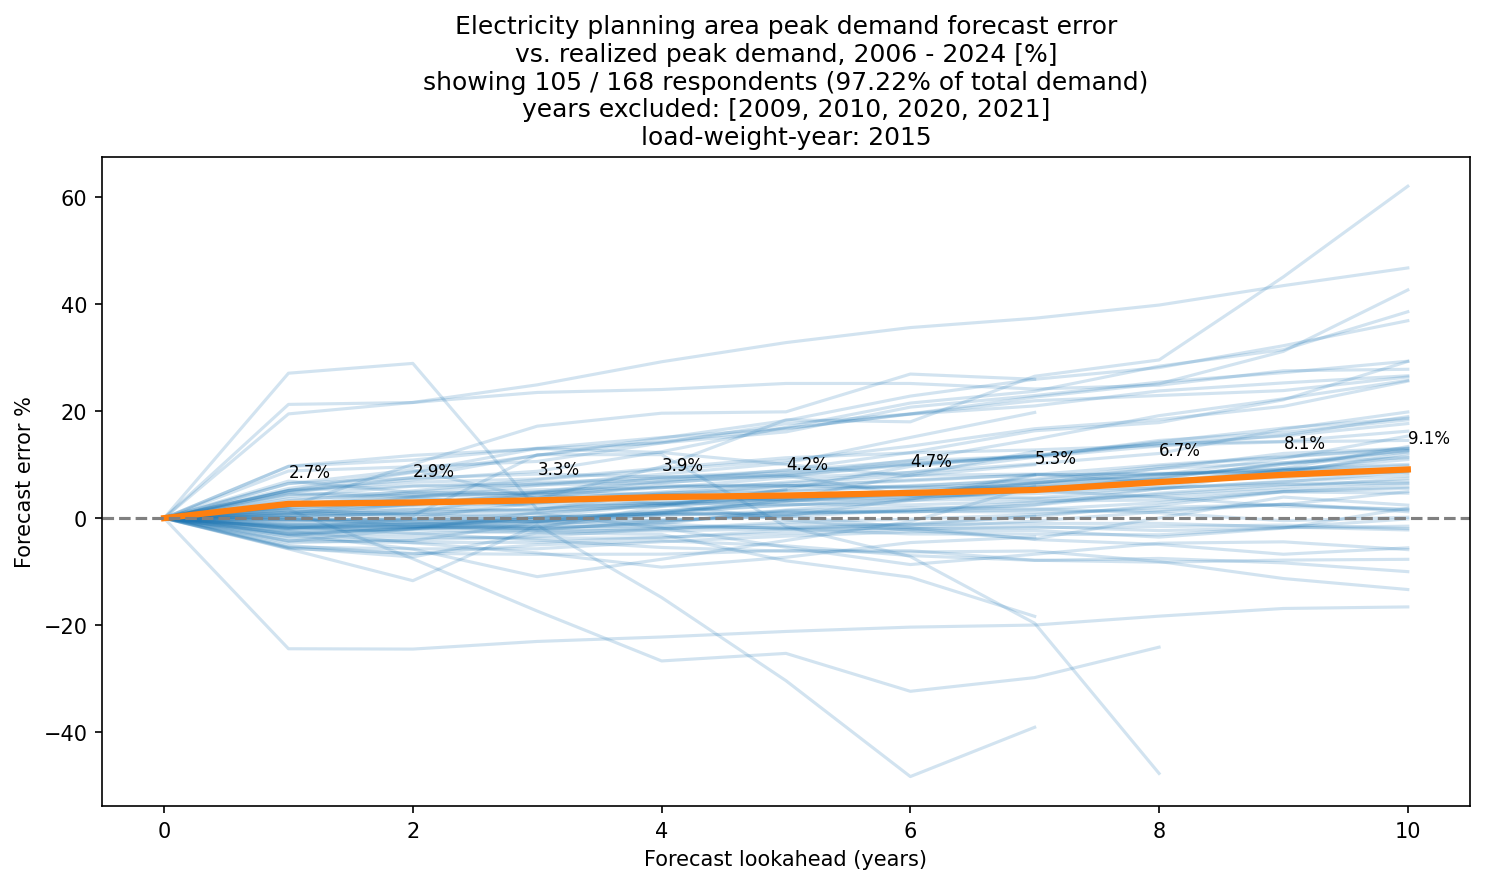

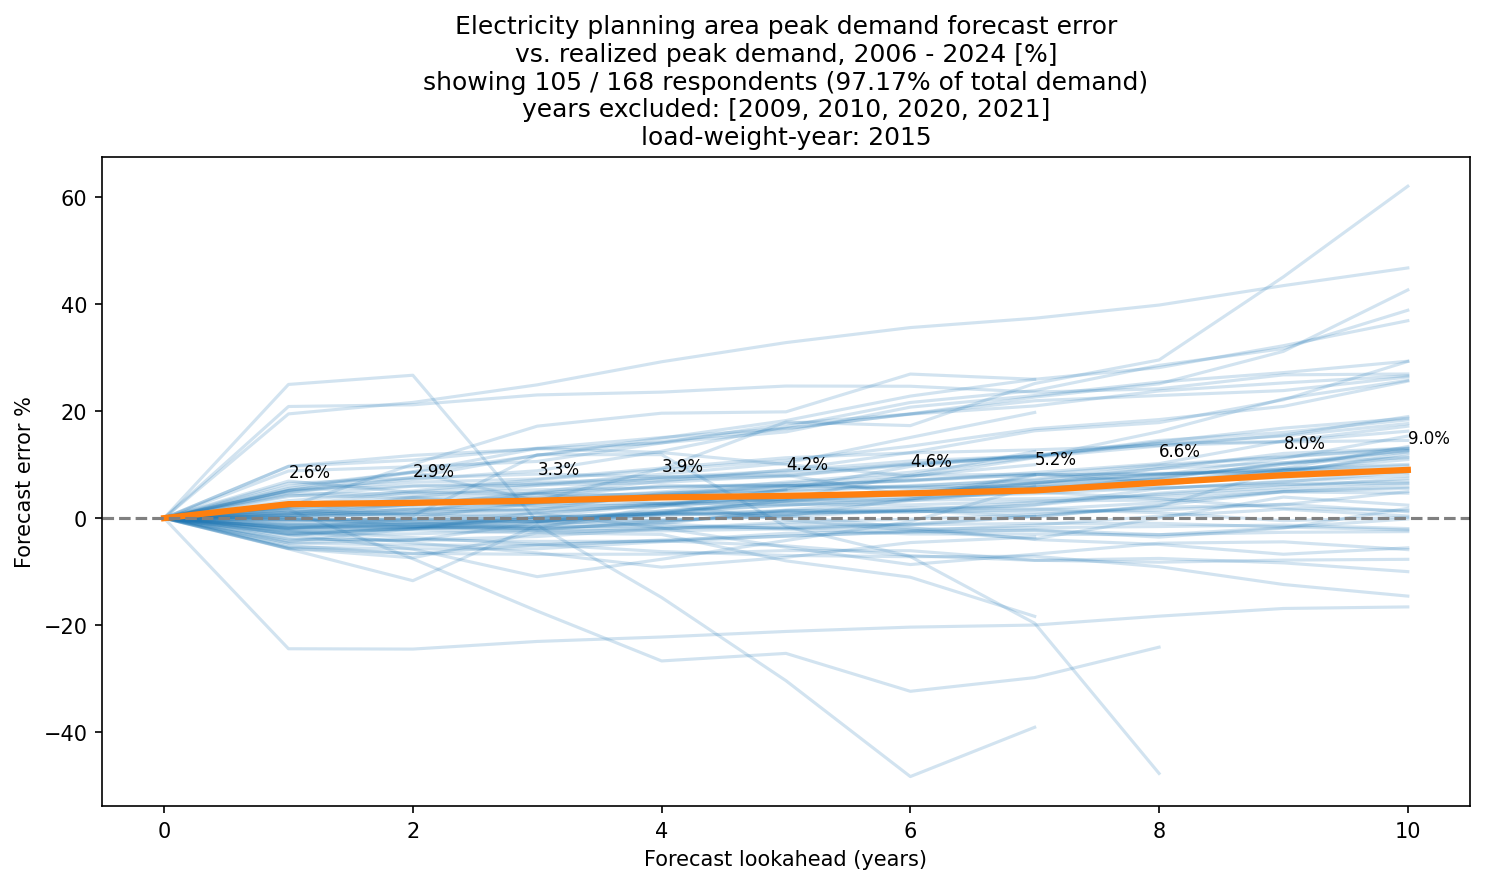

In [7]:
squid_plot(
    forecast,
    hourly_demand,
    respondents,
    end_weighting="total",
    demand_col="demand_imputed_pudl_mwh",
    years_to_drop=[2009, 2010, 2020, 2021],
    mean_annual_demand_threshold=5_000_000,
)

squid_plot(
    forecast,
    hourly_demand,
    respondents,
    end_weighting="total",
    demand_col="demand_reported_mwh",
    years_to_drop=[2009, 2010, 2020, 2021],
    mean_annual_demand_threshold=5_000_000,
)

## examples

Let's study a few respondents in some detail.

In [8]:
respondents.loc[respondents.respondent_id_ferc714 == 203]

,report_date,respondent_id_ferc714,demand_annual_mwh,population,area_km2,population_density_km2,demand_annual_per_capita_mwh,demand_density_mwh_km2,eia_code,respondent_type,respondent_name_ferc714,balancing_authority_id_eia,balancing_authority_code_eia,balancing_authority_name_eia,utility_id_eia,utility_name_eia
202,2006-01-01,203,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>
420,2007-01-01,203,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>
638,2008-01-01,203,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>
856,2009-01-01,203,526311360.0,47397272.0,1310364.25,36.171066,11.104254,401.65271,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>
1074,2010-01-01,203,581183360.0,47397272.0,1310364.25,36.171066,12.261958,443.528107,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>
1292,2011-01-01,203,553076864.0,47270264.0,1313718.25,35.98204,11.700313,421.001099,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>
1510,2012-01-01,203,497905632.0,42822920.0,1306034.5,32.788506,11.627083,381.23468,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>
1728,2013-01-01,203,503049344.0,53491640.0,1735762.75,30.817368,9.404261,289.814575,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>
1946,2014-01-01,203,668486912.0,54439376.0,1738843.625,31.307804,12.279474,384.443359,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>
2164,2015-01-01,203,657789568.0,54219756.0,1725798.25,31.417204,12.131916,381.150909,56669,balancing_authority,miso,56669,miso,midwest indep system operator,<NA>,<NA>


In [9]:
name_query = "dominion"
respondents.loc[
    respondents.respondent_name_ferc714.str.contains(name_query),
    ["respondent_id_ferc714", "respondent_name_ferc714"]
].drop_duplicates(keep="last")

,respondent_id_ferc714,respondent_name_ferc714
4034,111,"old dominion elec. coop., inc.-dom va pwr plan..."
4062,139,dominion energy south carolina
4105,182,"old dominion elec. coop., inc.-delmarva p&l pl..."
4115,192,pjm interconnection dominion hub ...


In [10]:
def indv_plot(
    forecast: pd.DataFrame,
    hourly_demand: pd.DataFrame,
    respondents: pd.DataFrame,
    id: int,
    demand_col: str = "demand_imputed_pudl_mwh",
    first_year: int = 2006,
    last_year: int = 2024,
    years_to_drop: list[int] = [],
):
    name = (
        respondents.loc[respondents.respondent_id_ferc714==id, ["respondent_id_ferc714", "respondent_name_ferc714"]
        ]
        .drop_duplicates(keep="last")
        .respondent_name_ferc714.iloc[0]
        .strip()
    )
    local_forecast = (
        forecast[
            (forecast.respondent_id_ferc714 == id)
            & (forecast["report_year"] >= first_year)
            & (forecast["report_year"] <= last_year)
        ]
        .copy()
    )
    local_demand = hourly_demand.loc[hourly_demand.respondent_id_ferc714 == id].copy()

    local_forecast = local_forecast.assign(
        lookahead=local_forecast.forecast_year - local_forecast.report_year,
        forecast=np.maximum(
            local_forecast.summer_peak_demand_forecast_mw,
            local_forecast.winter_peak_demand_forecast_mw,
        ),
    )

    local_demand = local_demand[
        local_demand.datetime_utc.dt.year == local_demand.report_date.dt.year
    ]
    local_demand = local_demand.assign(realized_year=local_demand.report_date.dt.year)
    local_demand.groupby("realized_year").agg(peak_demand_mwh=(demand_col, "max"))
    local_presquid = local_forecast.merge(
        local_demand.groupby("realized_year").agg(
            peak_demand_mwh=(demand_col, "max")
        ),
        how="inner",
        left_on="forecast_year",
        right_index=True,
        validate="m:1",
    )[
        [
            "respondent_id_ferc714",
            "report_year",
            "forecast_year",
            "lookahead",
            "forecast",
            "peak_demand_mwh",
        ]
    ]
    local_presquid = local_presquid.loc[~local_presquid.forecast_year.isin(years_to_drop)].copy()
    local_presquid["error"] = np.where(
        (local_presquid.forecast != 0) & (local_presquid.peak_demand_mwh != 0),
        (local_presquid.forecast - local_presquid.peak_demand_mwh)
        / local_presquid.peak_demand_mwh,
        0.0,
    )
    plt.figure()
    cmap = matplotlib.colormaps.get_cmap("BuGn")
    gradient = np.linspace(0, 1, local_presquid.report_year.nunique())
    colors = [matplotlib.colors.to_hex(cmap(i)) for i in gradient]
    for report_year, c in zip(sorted(local_presquid.report_year.unique()), colors):
        lpry = local_presquid.loc[local_presquid.report_year == report_year].sort_values(
            by="lookahead"
        )
        # add in 0 error at year 0
        added_row = lpry.iloc[0].copy()
        added_row.update({"lookahead": 0, "error": 0.0})
        lpry = pd.concat([added_row.to_frame().T, lpry])
        plt.plot(lpry.lookahead, lpry.error, label=report_year, c=c)
    plt.axhline(y=0, color="gray", linestyle="dashed")
    plt.xlabel("Forecast lookahead (years)")
    plt.ylabel("Forecast error %")
    plt.title(f"Forecast error for respondent id #{id}\n({name})")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

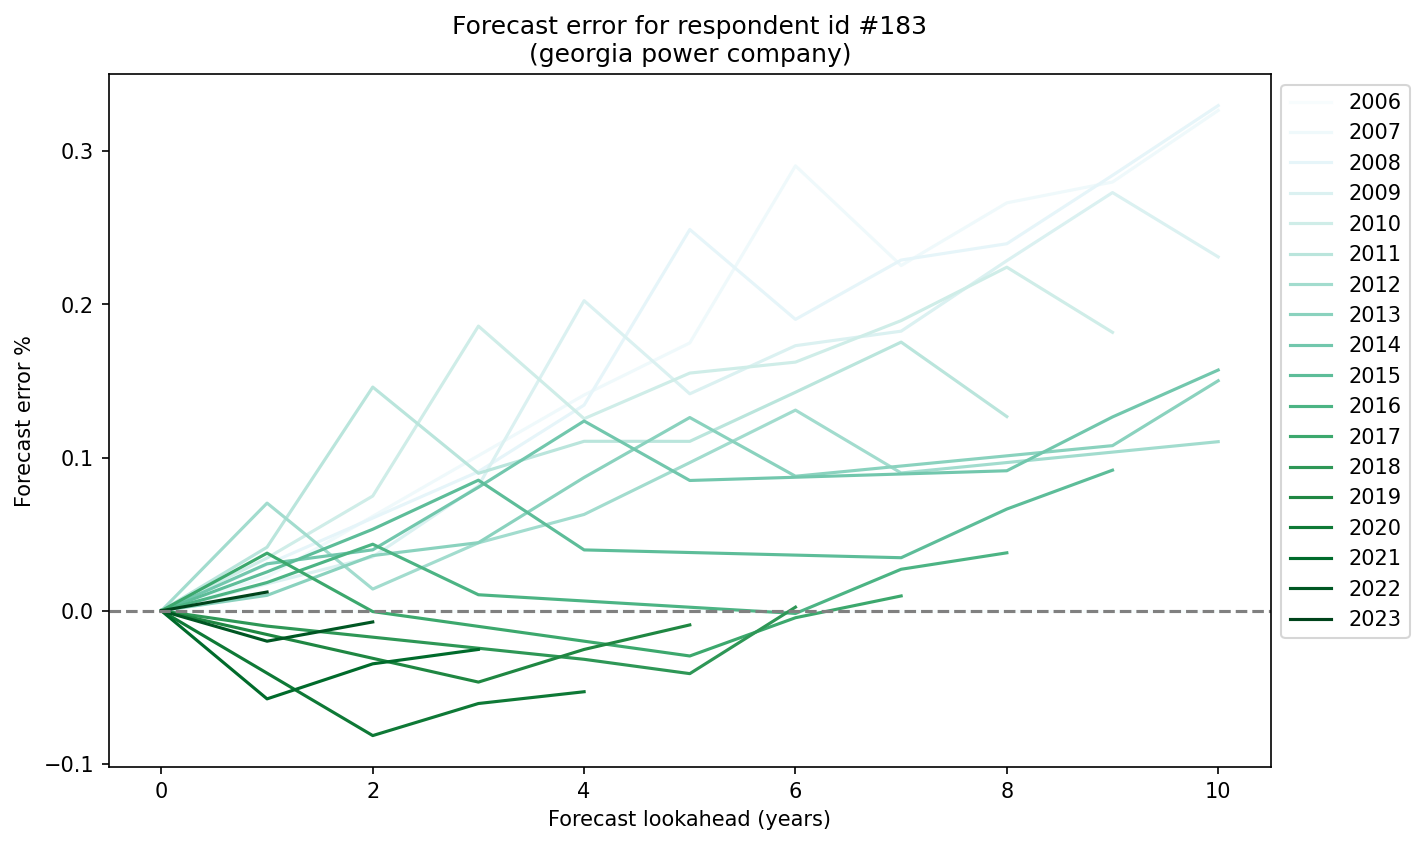

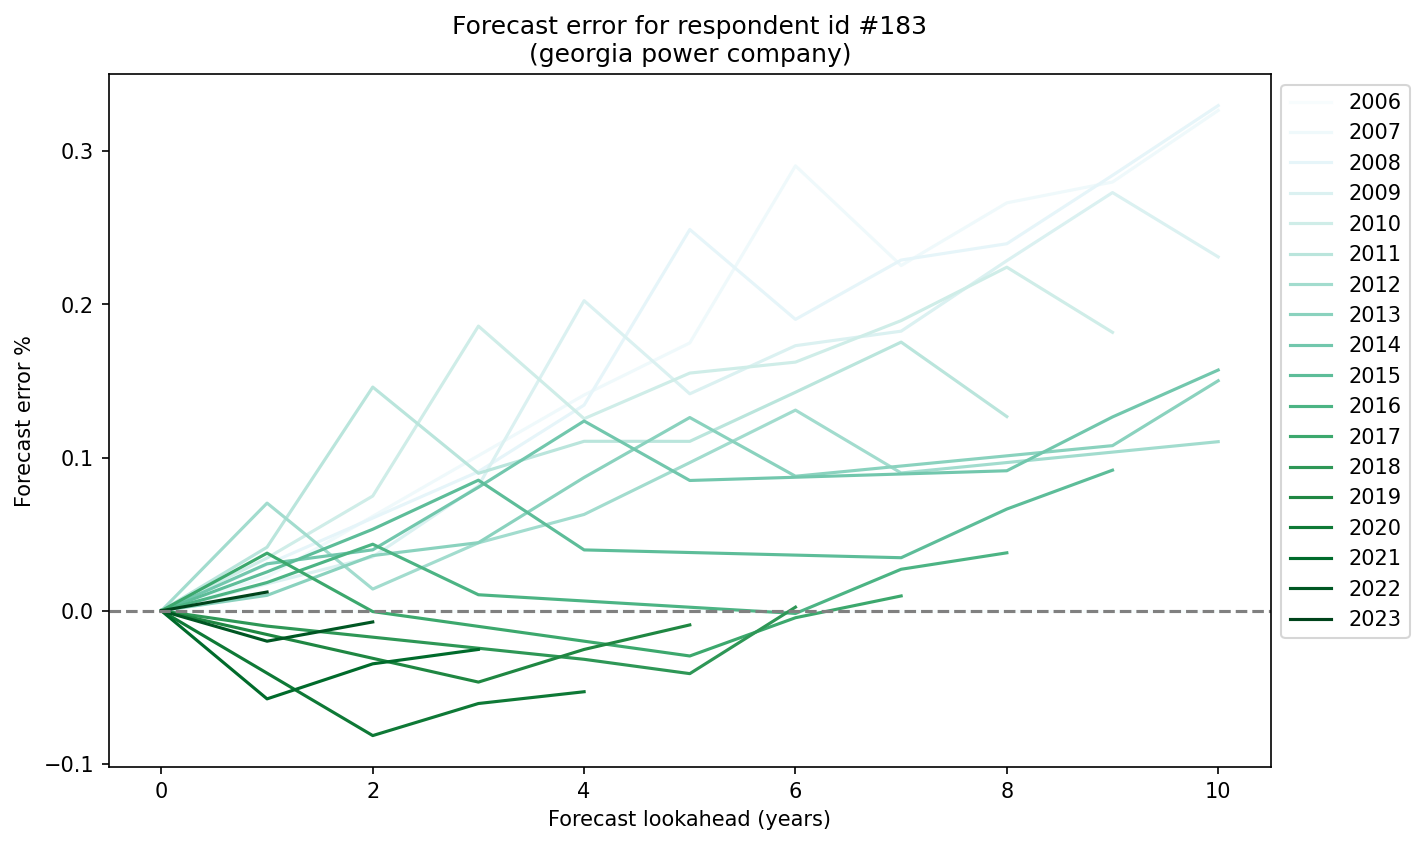

In [11]:
indv_plot(
    forecast,
    hourly_demand,
    respondents,
    demand_col="demand_reported_mwh",
    id=183,
    years_to_drop=[2009, 2010, 2020, 2021, 2025],
)
indv_plot(
    forecast,
    hourly_demand,
    respondents,
    demand_col="demand_imputed_pudl_mwh",
    id=183,
    years_to_drop=[2009, 2010, 2020, 2021, 2025],
)

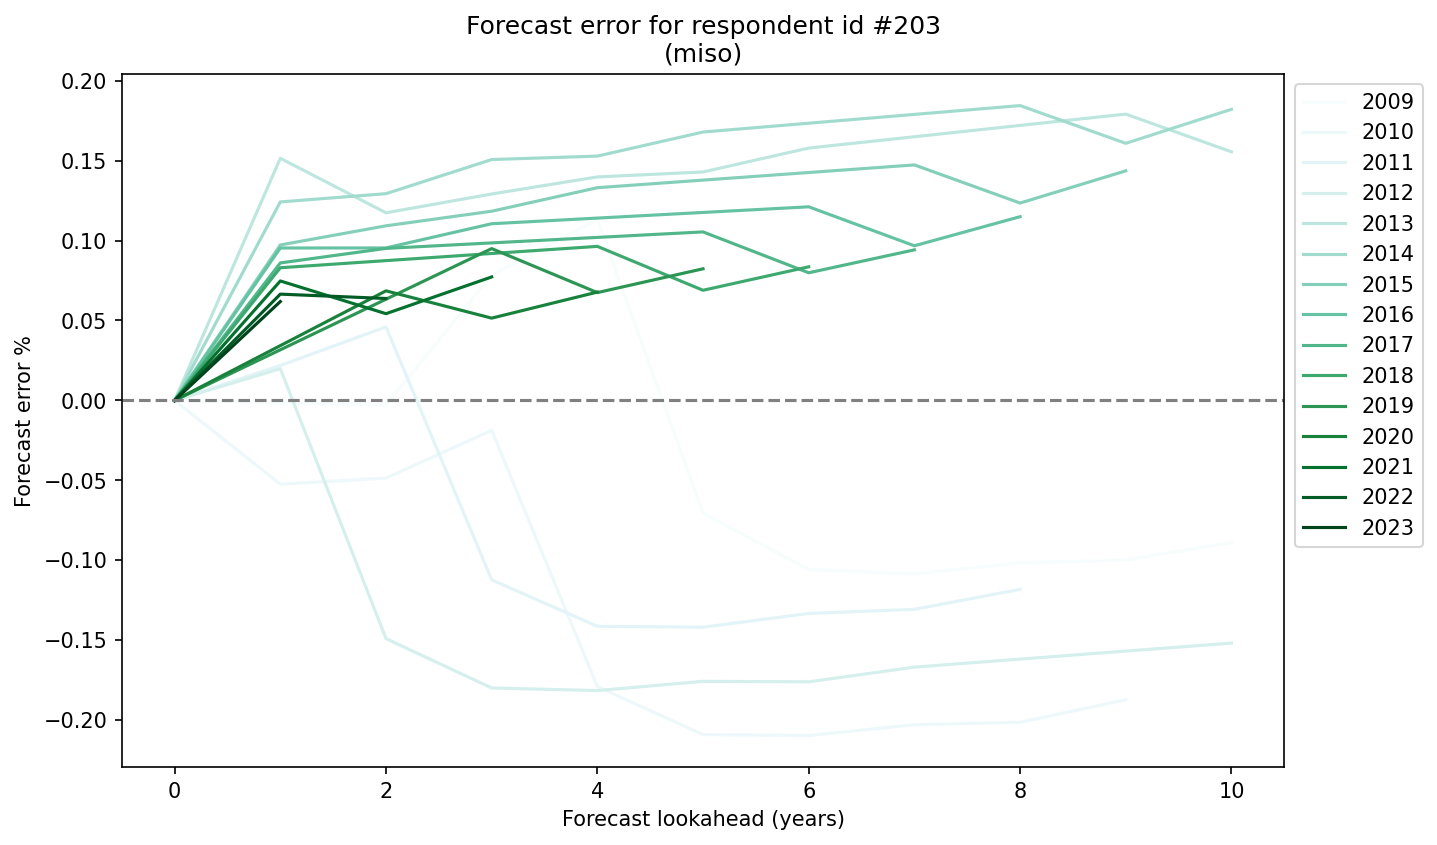

In [12]:
indv_plot(
    forecast,
    hourly_demand,
    respondents,
    id=203,
    years_to_drop=[2009, 2010, 2020, 2021, 2025],
)

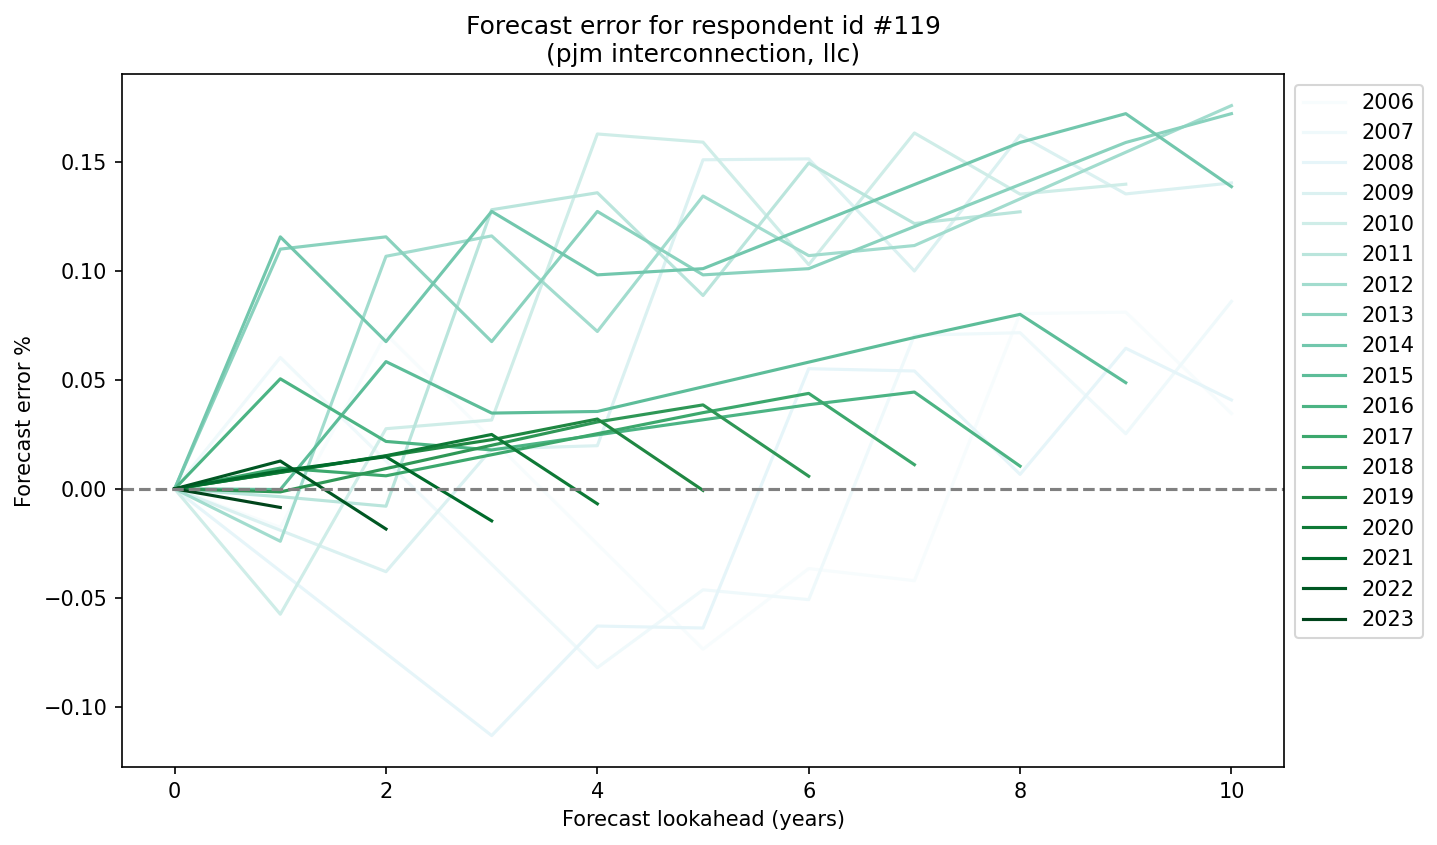

In [13]:
indv_plot(
    forecast,
    hourly_demand,
    respondents,
    id=119,
    years_to_drop=[2009, 2010, 2020, 2021, 2025],
)

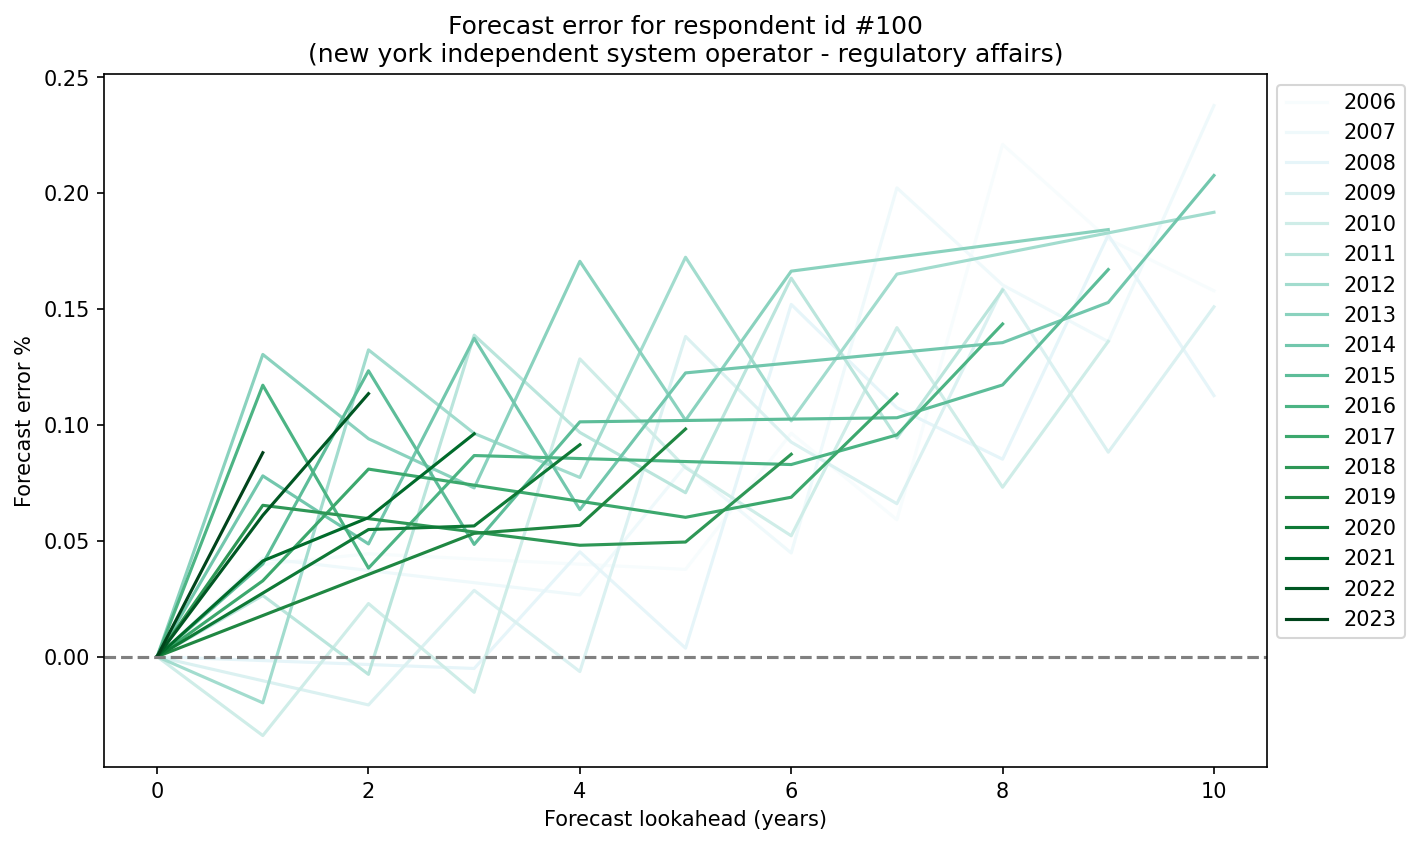

In [14]:
indv_plot(
    forecast,
    hourly_demand,
    respondents,
    id=100,
    years_to_drop=[2009, 2010, 2020, 2021, 2025],
)

Let's take a look at Georgia Power specifically, who have recently released their 2025 [Integrated Resource Plan](https://www.georgiapower.com/content/dam/georgia-power/pdfs/company-pdfs/2025-Integrated-Resource-Plan.pdf). Figure 5A shows their projected peak winter demand for the next 20 years. Our data here does seem to line up with the dark blue line present in the figure.

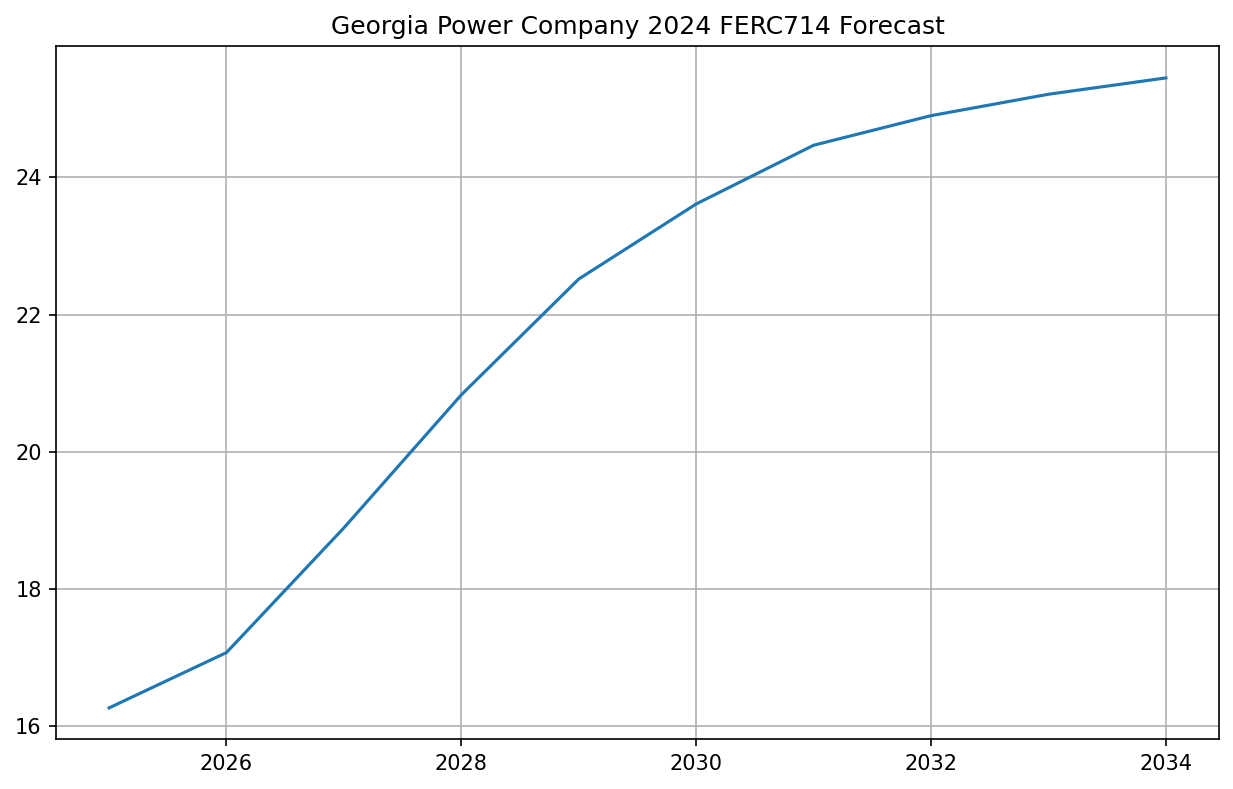

In [15]:
georgia = forecast.loc[
    (forecast.respondent_id_ferc714 == 183)
    & (forecast.report_year == 2024) 
].sort_values(by="forecast_year")
plt.plot(georgia["forecast_year"], georgia["winter_peak_demand_forecast_mw"] / 1000)
plt.grid()
plt.title("Georgia Power Company 2024 FERC714 Forecast")
plt.savefig("georgia_2023_forecast.png")

## planning areas with large changes in area

Are there any respondents whose area changed dramatically over the period of study? Zane pointed out that there has been a lot of consolidation of smaller planning areas. Can we catch any of that? And how does it affect our analysis above?

In [16]:
to_plot = []
for id in respondents.respondent_id_ferc714.unique():
    df = respondents.loc[respondents.respondent_id_ferc714 == id]
    name = df.respondent_name_ferc714.iloc[0].strip()
    # make sure we have some demand data
    if pd.isna(df.demand_annual_mwh.mean()):
        continue
    mean_demand_annual_mwh = int(df.demand_annual_mwh.mean())
    # make sure we have some area data
    df = df.dropna(subset="area_km2")
    if df.empty:
        continue
    # compute the change in area from the earliest to latest data point we have
    # and drop any respondents who haven't changed more than 10% overall
    pct_delta = (df.area_km2.iloc[-1] - df.area_km2.iloc[0]) / df.area_km2.iloc[0] * 100
    if abs(pct_delta) <= 10:
        continue
    to_plot.append(
        {
            "id": id,
            "name": name,
            "demand": mean_demand_annual_mwh,
            "x": df["report_date"],
            "y": df["area_km2"],
        }
    )
to_plot = sorted(to_plot, key=lambda d: d["demand"])

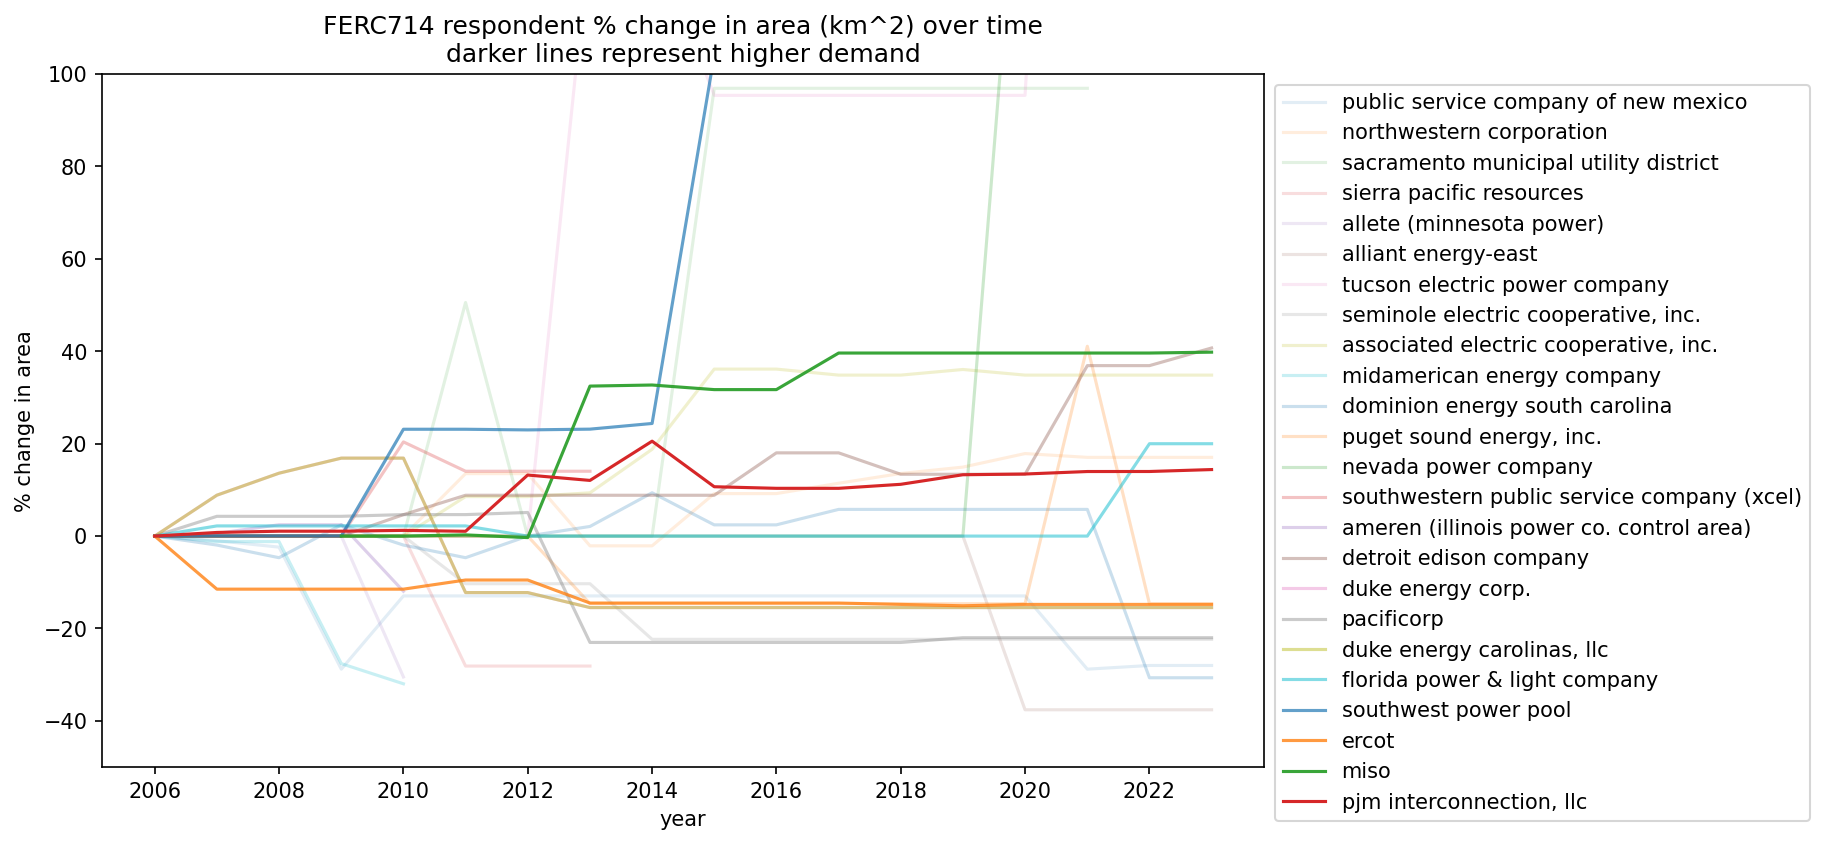

In [17]:
# prepare color gradient based on log10 mean demand
cmap = matplotlib.colormaps.get_cmap("BuGn")
demands = np.asarray([np.log10(d["demand"]) for d in to_plot])
gradient = (demands - demands[0]) / (demands[-1] - demands[0])
colors = [matplotlib.colors.to_hex(cmap(i)) for i in gradient]

# only plot large enough mean demand respondents
for i, resp in enumerate(to_plot):
    if resp["demand"] < 10**7:
        continue
    plt.plot(
        resp["x"],
        100 * (resp["y"] - resp["y"].iloc[0]) / resp["y"].iloc[0],
        alpha=gradient[i] ** 2,
        # color=colors[i],
        label=f"{resp['name']}",
    )
plt.ylim(-50, 100)
plt.legend(bbox_to_anchor=(1, 1))
plt.title(
    "FERC714 respondent % change in area (km^2) over time\ndarker lines represent higher demand"
)
plt.xlabel("year")
plt.ylabel("% change in area")
plt.savefig("/kaggle/working/area_changes.png", bbox_inches="tight")
plt.show()